In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle, randint
import numpy as np
import future
from keras.applications import VGG16
from PIL import Image

import matplotlib.pyplot as plt
import os, shutil
from os import listdir, mkdir
from os.path import join, isfile, isdir, exists
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
def make_dir_helper(dir_path):
    if not os.path.exists(dir_path):
        mkdir(dir_path)
        return True
    return False

In [3]:
def delete_dir_helper(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        return True
    return False

In [4]:
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
    model.summary()

In [5]:
def is_jpeg(fname):
    return fname.split('.')[-1] == 'jpg'

In [6]:
def get_class_names(base_dir):
    return [dname for dname in listdir(base_dir) if isdir(join(base_dir, dname))]

In [7]:
#project_dir_name = join('Esri Project')
project_dir_name = join('desktop','Esri Project')
original_dataset_dir = join(os.path.expanduser('~'), project_dir_name, 'original data 2');
base_dir =  join(os.path.expanduser('~'), project_dir_name, 'data');
base_scripts_dir =  join(os.path.expanduser('~'), project_dir_name, 'scripts');
model_dir =  join(os.path.expanduser('~'),  project_dir_name, 'models');

MODEL_FILE_NAME = 'map_multi_model_6.h5'

CLASSES_TO_CLASSIFY = get_class_names(original_dataset_dir)
print(CLASSES_TO_CLASSIFY)
NO_OF_CLASSES = len(CLASSES_TO_CLASSIFY)

ext = '.jpg'
IMAGE_SIZE = 150
EPOCHS = 30
NO_TRAINING_SAMPLES = 70
BATCH_SIZE = 15
STEPS_PER_EPOCH = 5

train_dir = join(base_dir, 'train')
validation_dir = join(base_dir, 'validation')
test_dir = join(base_dir, 'test')
model_file_path = join(model_dir, MODEL_FILE_NAME)

# Delete the previous data folder and all its contents
delete_dir_helper(base_dir)

make_dir_helper(base_dir)
make_dir_helper(model_dir)

# Make base directories
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)

for classes in CLASSES_TO_CLASSIFY:
    
    train_class_dir = join(train_dir, classes)
    validation_class_dir = join(validation_dir, classes)
    test_class_dir = join(test_dir, classes)
    
    # Make train sub directories
    make_dir_helper(train_class_dir)
    make_dir_helper(validation_class_dir)
    make_dir_helper(test_class_dir)
    
    
    original_dataset_class_dir = join(original_dataset_dir, classes)
    fnames = [fname for fname in listdir(original_dataset_class_dir) if isfile(join(original_dataset_class_dir,fname)) and is_jpeg(fname)]
    
    shuffle(fnames)
    
    for idx, fname in enumerate(fnames):
        
        src_dir = join(original_dataset_class_dir, fname)
        if idx < 70:
            dst_dir = join(train_class_dir, fname)
            shutil.copyfile(src_dir, dst_dir)
        elif 70 <= idx < 100:
            dst_dir = join(validation_class_dir, fname)
            shutil.copyfile(src_dir, dst_dir)
            
            dst_dir = join(test_class_dir, fname)
            shutil.copyfile(src_dir, dst_dir)

['agricultural', 'airplane', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'harbor', 'overpass', 'parkinglot', 'river', 'storagetanks']


In [8]:
is_model_from_file = False
model = None
if exists(model_file_path):
    print('Found saved model with name ' + MODEL_FILE_NAME)
    model = load_model(model_file_path)
    compile_model(model)
else:
    print('NO saved model with name ' + MODEL_FILE_NAME)

Found saved model with name map_multi_model_6.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                1548      
Total params: 15,764,940
Trainable params: 15,764,940
Non-trainable params: 0
_________________________________________________________________


In [9]:
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       vertical_flip=True,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  
            batch_size=BATCH_SIZE,
            class_mode='categorical')  

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

Found 840 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


In [10]:
    for idx, (data_batch, labels_batch) in enumerate(train_generator):
        print('data batch:', data_batch.shape)
        print('labels batch:', labels_batch.shape)
        break

data batch: (15, 150, 150, 3)
labels batch: (15, 12)


In [11]:
#     model = models.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(6, activation='softmax'))

In [12]:
    model = models.Sequential()
    conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    conv_base.trainable = False
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NO_OF_CLASSES, activation='softmax'))

In [13]:
    compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/30
10/10 [==============================] - 86s - loss: 3.1072 - acc: 0.1133 - val_loss: 3.0208 - val_acc: 0.0800
Epoch 2/30
10/10 [==============================] - 54s - loss: 2.9446 - acc: 0.1200 - val_loss: 2.7399 - val_acc: 0.1800
Epoch 3/30
10/10 [==============================] - 54s - loss: 2.8935 - acc: 0.1333 - val_loss: 2.7537 - val_acc: 0.1600
Epoch 4/30
10/10 [==============================] - 54s - loss: 2.8783 - acc: 0.1067 - val_loss: 2.4301 - val_acc: 0.3733
Epoch 5/30
10/10 [==============================] - 54s - loss: 2.4840 - acc: 0.2733 - val_loss: 2.0324 - val_acc: 0.3133
Epoch 6/30
10/10 [==============================] - 54s - loss: 2.2311 - acc: 0.3533 - val_loss: 1.8317 - val_acc: 0.5200
Epoch 7/30
10/10 [==============================] - 54s - loss: 1.9172 - acc: 0.4667 - val_loss: 1.7240 - val_acc: 0.4733
Epoch 8/30
10/10 [==============================] - 54s - loss: 1.7378 - acc: 0.5333 - val_loss: 1.4694 - val_acc: 0.5733
Epoch 9/30
10/10 [======

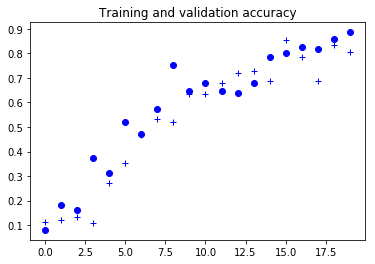

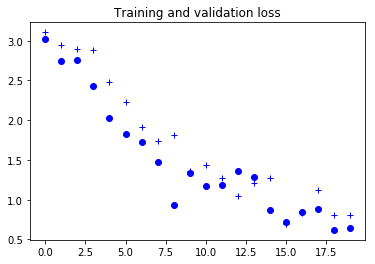

In [14]:
    callbacks = [
        EarlyStopping(monitor='acc', patience=3, mode='auto'),
        ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
    ]
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=10)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b+')
    plt.plot(epochs, val_acc, 'bo')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'b+')
    plt.plot(epochs, val_loss, 'bo')
    plt.title('Training and validation loss')

    plt.show()

In [17]:
fnames = []
target_dir = test_dir
# dnames = [os.path.join(target_dir, dname) for dname in os.listdir(target_dir)]
dnames = [os.path.join(target_dir, dname) for dname in os.listdir(target_dir)]

for dname in dnames:
    
    fnames =([os.path.join(dname, fname) for fname in os.listdir(dname)])
    
    cur_class = dname.split('\\')[-1]
    print(cur_class)

    NO_OF_FIG = 15
    correct_predict = 0
    
    max_indices = []
    
    for index, img_path in enumerate(fnames):
          
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
        
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        prediction = model.predict(x)[0]
        
        # print(prediction)
        # prediction = [round(x, 2) for x in prediction]
        
        # img.thumbnail((50,50), Image.ANTIALIAS)
        # imgplot = plt.imshow(img)
        
        max_val = np.amax(prediction)
        max_index = np.argmax(prediction)
        max_indices.append('idx:' + str(max_index) + 'val:' + str(max_val))
        title = ''

        if prediction[max_index] > 0.7:
            pred_class = CLASSES_TO_CLASSIFY[max_index]
            title += pred_class + ' '
          
            if pred_class == cur_class:         
                correct_predict +=1
          
#       title += str(prediction)
#       plt.axis('off')
#       plt.title(title)
    
    # print(max_indices)
    print('Accuracy of class:' + str(correct_predict / len(fnames) * 100))
    # plt.show()

agricultural
Accuracy of class:50.0
airplane
Accuracy of class:100.0
buildings
Accuracy of class:66.66666666666666
chaparral
Accuracy of class:100.0
denseresidential
Accuracy of class:76.66666666666667
forest
Accuracy of class:56.666666666666664
freeway
Accuracy of class:100.0
harbor
Accuracy of class:96.66666666666667
overpass
Accuracy of class:66.66666666666666
parkinglot
Accuracy of class:100.0
river
Accuracy of class:3.3333333333333335
storagetanks
Accuracy of class:93.33333333333333
